# Analysing decisions in data analysis

H. Sherry Zhang (University of Texas at Austin)  
Roger D. Peng (University of Texas at Austin)

this is the abstract

# Introduction

Something about “analysis review” - Roger thinks it’s a better to have a new word for this.

provide a baseline understand - place to start

demonstrate - analytically homogeneous - the table won’t look like that

In this work, we design a tabular format to record the choices made by analysts during data analysis. Using large language models, we automatically extract these choices from a set of research papers focused on specific topics, e.g. air pollution modelling. This allows us to analyze these choices as data – tracking how they’ve changed over time or query the possible methodologies used in similar studies. We also introduce a workflow to cluster paper based on decision similarity, using both the decisions themselves and the justifications authors provide for their choices.

# Background

Data analysis as an complicated, iterative process to make sense \[ref\] of the data collected. The iterative process of formulating hypothesis @jun2022.

Choices are made at nearly every stage of data analysis, ranging from variable pre-processing variables, variable and lag selection in model formulation, to the specification of smoothing parameter during model construction. These possible choices contribute to what @gelman2014 describe as the “garden of forking paths”. These choices can introduce substantial variability in results, which has been demonstrated in many-analyst experiments, where independent teams analyzing the same dataset to answer a pre-defined research question often arrive at markedly different conclusions. A prominent example is @silberzahn2018 where researchers reported a wide range of point estimates and 95% confidence intervals for the effect of soccer players’ skin tone on the number of red cards awarded by referees (odds ratio from 0.89 to 2.93). Similar findings have emerged in other domains, including structural equation modeling \[@sarstedt2024\], applied microeconomics \[@huntington-klein2021\], neuroimaging \[@botvinik-nezer2020\], and ecology and evolutionary biology \[@gould2025\].

Another line of work focuses on developing software tools to support analysts in making more informed decisions. For example, the `Tisane` package \[@jun2022\] integrates conceptual ideas, such as DAGs, and modelling structure (group/ cluster/ hierarchical structure), to assist junior researchers in specifying GLM and GLMM model. The `DeclareDesign` package \[@blair2019\] introduces the MIDA framework for researchers to declare, diagnose, and redesign their analyses to produce a distribution of the statistic of interest. This approach has been applied in randomized controlled trial \[@bishop2024\] .

The `multiverse` package

-   facilitates the specification and execution of multiple parallel choices for sensitivity analysis, allowing researchers to systematically explore how different choices affect results and to report the range of plausible outcomes that arise from alternative analytic paths.

Study decisions in data analysis:

-   interview analysts and researchers to provide recommendation for data analysis practices \[@kale2019; @alspaugh2019; @liu2020\].
-   @liu2020 provides visualization to communicate the decision processes through the Analytic Decision Graphs (ADG)
-   @simson2025 conducts a participatory AI study to demonstrate the “garden of forking paths” of decisions in data analysis and how it affects ML fairness

# Extracting decisions from data analysis

## Decisions in data analysis

-   what constitute a decision in data analysis
-   adapt from the tidy data principle - each row is a decision @wickham2014
-   some decisions are related to how the variable is estimated spatially and temporally
-   model level decisions on how the model is estimated spatially (for multi-site analyses) and/or temporally (different treatments for years or seasons)
-   extract the exact text from the paper

An example decisions may look as follows:

| Paper | ID | Model | variable | method | parameter | type | reason | decision |
|--------|--------|--------|--------|--------|--------|--------|--------|--------|
| ostro | 1 | Poisson regression | temperature | smoothing spline | degree of freedom | parameter | NA | 3 degree of freedom |
| ostro | 2 | Poisson regression | temperature | smoothing spline | degree of freedom | temporal | NA | 1-day lag |
| ostro | 3 | Poisson regression | relative humidity | LOESS | smoothing parameter | parameter | to minimize Akaike’s Information Criterion | NA |
| ostro | 4 | Poisson regression | model | NA | NA | spatial | to account for variation among cities | separate regression models fit in each city |

However, decisions statements are often implicit, and the justifications may not directly align with the decisions themselves. We identify four common anomalies:

1.  **Authors may combine multiple decisions into a single sentence** for coherence and conciseness of the writing. Consider the following excerpt from @ostro2006:

> Other covariates, such as day of the week and smoothing splines of 1-day lags of average temperature and humidity (each with 3 df), were also included in the model because they may be associated with daily mortality and are likely to vary over time in concert with air pollution levels.

This sentence contains four decisions: two for temperature (the temporal lag and the smoothing spline parameter) and two for humidity. These decisions should be structured as separate entries.

1.  **The justification does not directly address the decision choice.** In the example above, the stated rationale (“and are likely to vary over time in concert with air pollution levels”) supports the general inclusion of temporal lags but does not justify the specific choice of 1-day lag over alternatives, such as 2-day average of lags 0 and 1 (lag01) and single-day lag of 2 days (lag2). As such, the reason field should be recorded as NA.

2.  **Some decisions may be omitted because they are data-driven**. For instance, @katsouyanni2001 states:

> The inclusion of lagged weather variables and the choice of smoothing parameters for all of the weather variables were done by minimizing Akaike’s information criterion.

In this case, while the method of selection (minimizing AIC) is specified, the actual degree of freedom used is not. Such data-driven decisions may be recorded with “NA” in the decision field, but the reason field should still be recorded as “by minimizing Akaike’s information criterion”

1.  **Information required to interpret the decision may be distributed across multiple sections**. In the previous example, “weather variables” refers to mean temperature and relative humidity, as defined earlier in the text. This requires cross-referencing across sections to identify the correct variables associated with each modeling choice.

## Automatic reading of literature with LLM

While decisions can be extracted manually from the literature, this process is labor-intensive and time-consuming. Recent advances in Large Language Models (LLMs) have demonstrated potential for automating the extraction of structured information from unstructured text \[ref\]. In this work, we use LLMs to automatically identify decisions made by authors during their data analysis processes.

Text recognition from PDF document relies on Optical Character Recognition (OCR) to convert scanned images into machine-readable text – capability currently offered by Antropic Claude and Google Gemini. We instruct the LLM to generate a markdown file containing a JSON block that records extracted decisions, which can then be read into statistical software for further analysis. The exact prompt feed to the LLM is provided in the Appendix. The `ellmer` package \[@ellmer\] in R is used to connect to the Gemini and Claude API, providing the PDF attachment and the prompt in a markdown file as inputs. @fig-llm shows the overall workflow for decision extract using LLMs.

## Review the LLM output

-   something about result validation of LLM output
-   The sensitivity of the two models to the prompt and the model parameters, such as temperature and seed, is discussed in @sec-sensitivity.

The shiny app is designed to provide users a visual interface to review and edit the decisions extracted by the LLM from the literature. The app allows three actions from the users: 1) *overwrite* – modify the content of a particular cell, equivalently `dplyr::mutate(xxx = ifelse(CONDITION, "yyy" , xxx))`, 2) *delete* – remove a particular cell, `dplyr::filter(!(CONDITION))`, and 3) *add* – manually enter a decision, `dplyr::bind_rows()`. @fig-shiny illustrates the *overwrite* action in the Shiny application, where users interactively filter the data and preview the rows affected by their edits—in this case, changing the model entry from “generalized additive Poisson time series regression” to the less verbose “Poisson regression”. Upon confirmation, the corresponding `tidyverse` code is generated, and users can download the edited table and incorporate the code into their R script.

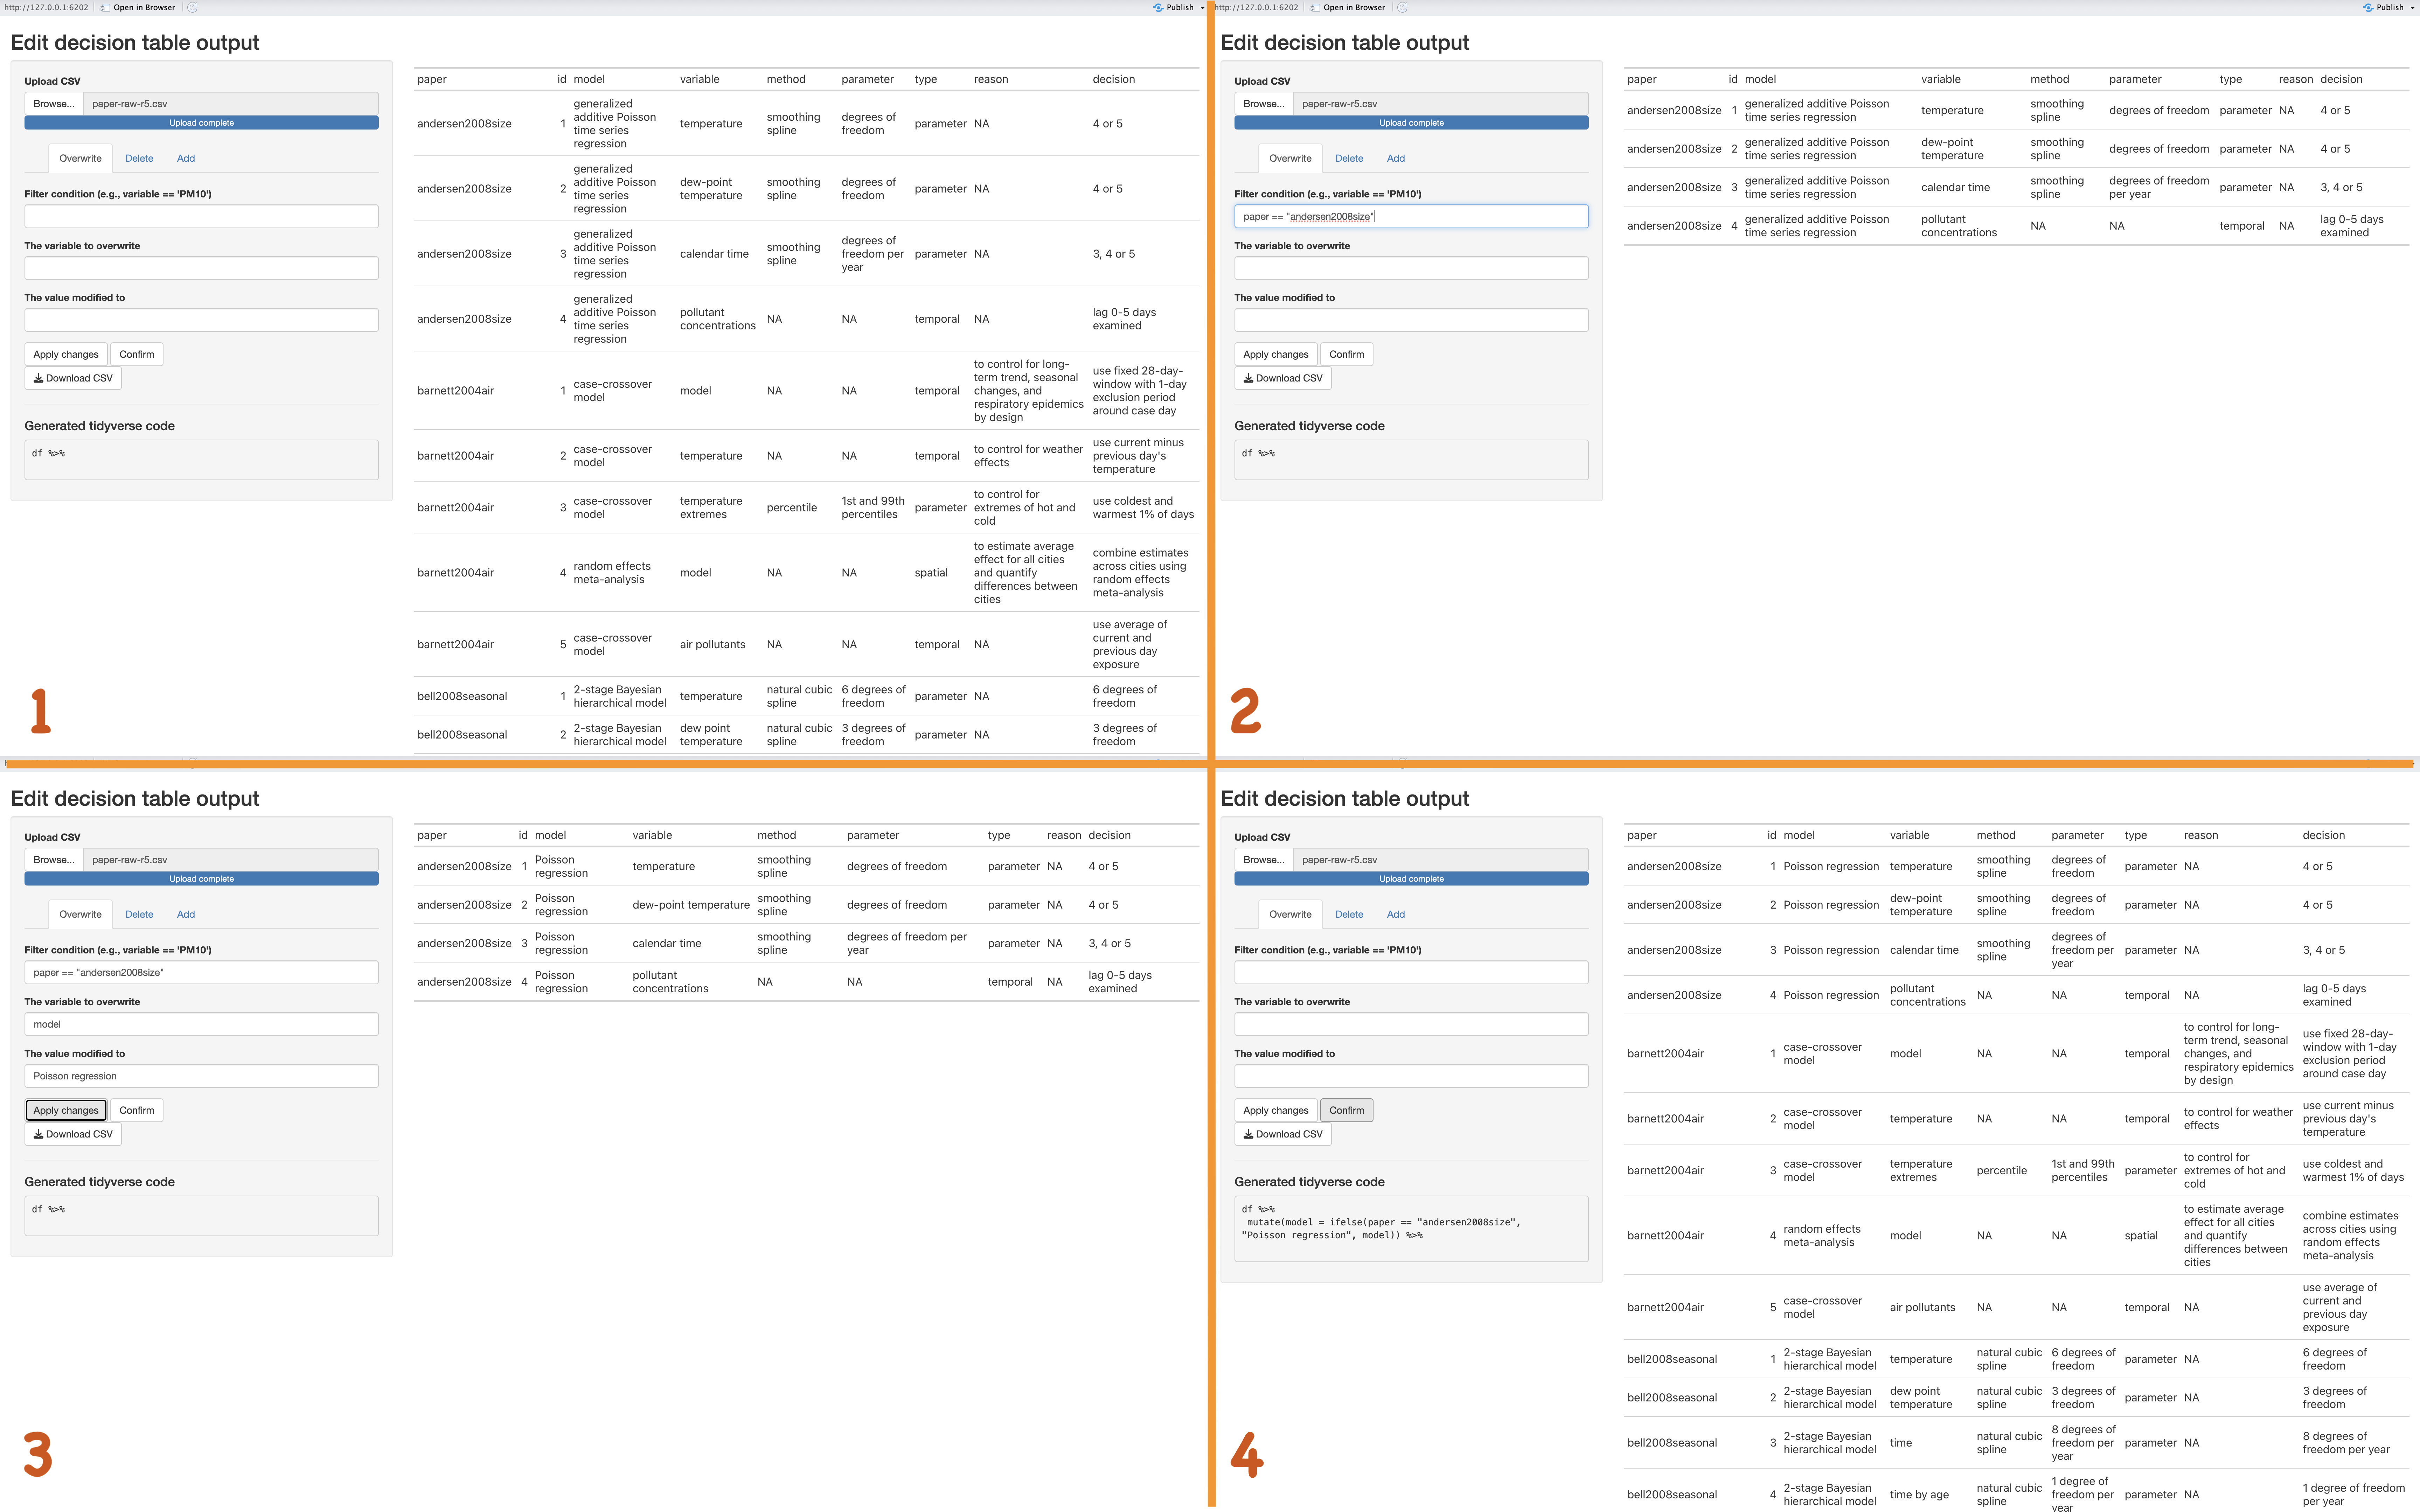

In [ ]:
knitr::include_graphics("figures/shiny.png")

# Calculating paper similarity

-   pre-processing
    -   standardize statistical methods its corresponding parameters (LOESS, smoothing spline, etc)
    -   group variables into broader categories: time, temperature, humidity, PM
-   identify the most frequent analysis decisions across papers
-   retain only papers that report more than x such decisions
-   measure similarity between decisions and their justificaiton using NLP
    -   word embedding with attention mechanism, instead of bag of word,
    -   specific NLP models (default to `bert-base-uncased`), aggregation methods from word to text
-   compute paper similarity score for each paper pair by aggregating decision-level compoarisons
    -   check/ report on the number of decisions compared in each paper pair
-   similarity score can serve as the distance matrix to cluster papers by their similarity on decision choices

# Results

## Air pollution mortality modelling

Decision quality summary

-   look at for one type of decision (time) - what are the choices made by different papers
-   look at whether decisions changes across time
-   Visualize the decision database: apply clustering algorithm and visualize the database through `sigma.js`

## Sensitivity analysis

sensitivity of the pipeline: 1) LLM, 2) text model, 3) prompt, 4) LLM parameters

-   standard `BERT` \[@devlin2019\], `Roberta` \[@liu\]: trained on a much larger dataset (160GB v.s. BERT’s 15GB), `transformer-xl` \[@dai\], `xlnet` by Google Brain \[@yang\], and two domain-trained BERT models: `sciBert` \[@beltagy2019\] and `bioBert`\[@lee2020\], trained on PubMed and PMC data.

-   A section on reproducibility of LLM outputs: prompt experiment (see if there are papers discussing this: https://arxiv.org/pdf/2406.06608)

# Discussion

-   Only prompting engineering is used to extract decisions from the literature. We expect that fine-tuning the model on statistical or domain-specific literature to yield more robust performance on the same document, though it would require substantially more training effort.
-   people from the NYU-LMU workshop are interested to have code script attached as well because people can do one thing in the script but report another in the paper - it would be interesting to compare the paper and the script with some syntax extraction.
-   Validation of the output:

the nature of the task: Our task involve a reasoning component in that it requires casual reasoning to identify the decisions made by the authors, and its justification/ rationale, rather than purely summarizing the text through pattern-matching.

# Reference